In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler


In [3]:
df_train = pd.read_csv('credit_installment2_id5.csv')
df_eval = pd.read_csv('credit_installment2_evaluation_data.csv')

In [4]:
df_train['Stress'].mean()

0.19901396608102034

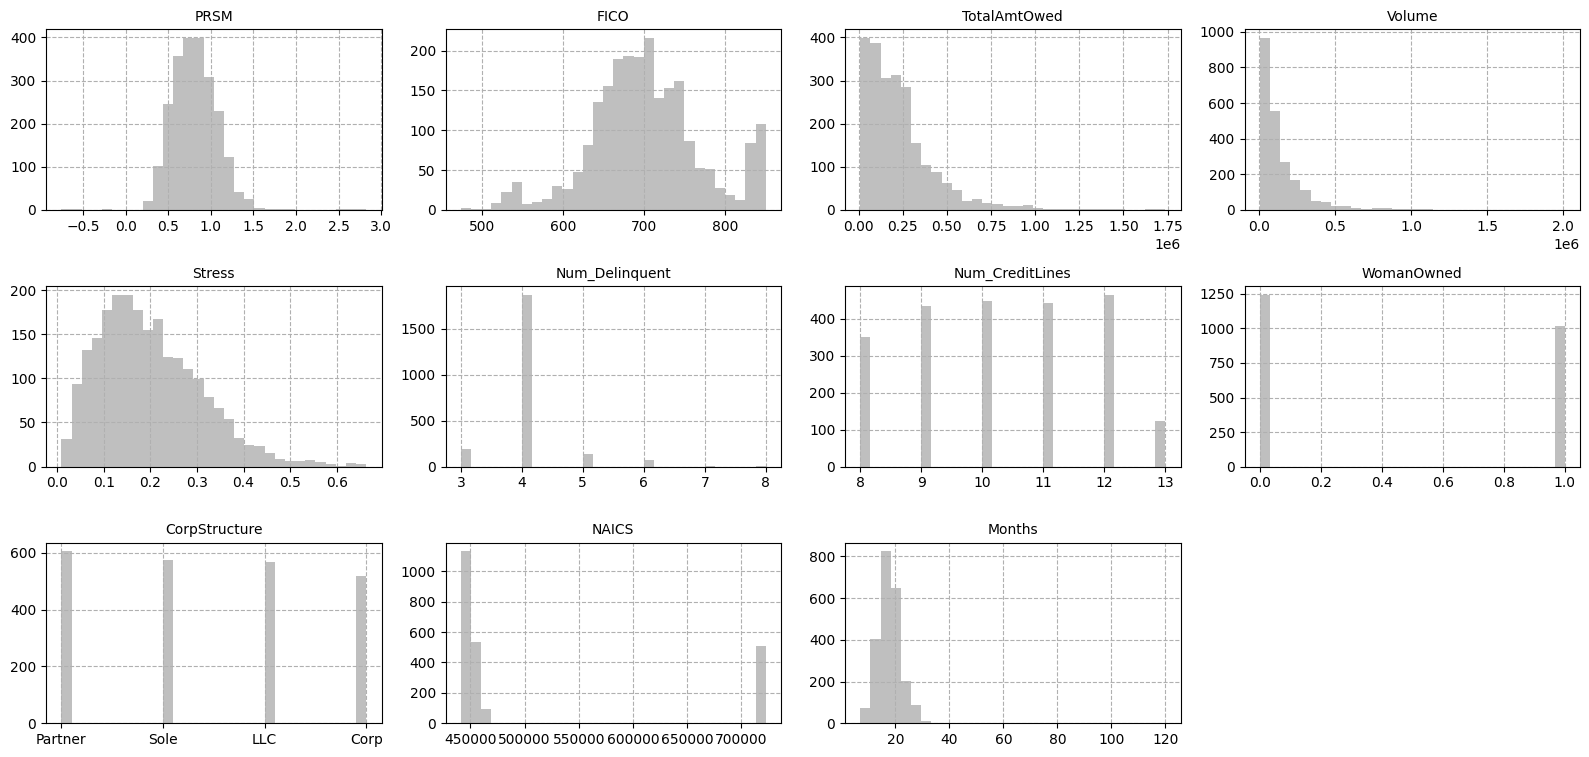

In [5]:
plt.figure(figsize=(16, 10), dpi=100)

for n, i in enumerate(df_train.iloc[:, 0:].columns):
    plt.subplot(4, 4, n+1) 
    plt.title(i, fontsize=10)  
    plt.grid(linestyle='--')
    df_train[i].hist(color='grey', alpha=0.5, bins=30)  

plt.tight_layout()
plt.show()

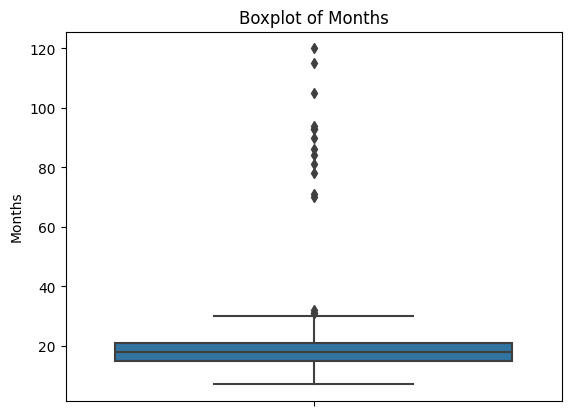

In [6]:
sns.boxplot(y=df_train["Months"])
plt.title("Boxplot of Months")

plt.show()

In [7]:
df_train.head()

,PRSM,FICO,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,CorpStructure,NAICS,Months
0,0.653303,678,255896.409,124488.146949,0.171299,4,9,0,Partner,445292,25
1,0.560278,621,212676.403,232931.138170,0.076087,5,10,0,Partner,459210,18
2,0.886459,697,66598.098,30705.514372,0.180744,4,12,1,Sole,445250,19
3,0.828696,725,389470.341,167001.899916,0.194344,4,11,0,Partner,444140,17
4,0.820346,670,44152.527,27402.840948,0.134270,4,11,1,Sole,445240,27


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266 entries, 0 to 2265
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PRSM             2266 non-null   float64
 1   FICO             2266 non-null   int64  
 2   TotalAmtOwed     2266 non-null   float64
 3   Volume           2266 non-null   float64
 4   Stress           2266 non-null   float64
 5   Num_Delinquent   2266 non-null   int64  
 6   Num_CreditLines  2266 non-null   int64  
 7   WomanOwned       2266 non-null   int64  
 8   CorpStructure    2266 non-null   object 
 9   NAICS            2266 non-null   int64  
 10  Months           2266 non-null   int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 194.9+ KB


In [9]:
df_train['CorpStructure'].value_counts()

Partner    605
Sole       575
LLC        566
Corp       520
Name: CorpStructure, dtype: int64

In [10]:
df_train["Delinquent_Credit_Ratio"] = df_train["Num_Delinquent"] / (df_train["Num_CreditLines"])
df_eval["Delinquent_Credit_Ratio"] = df_eval["Num_Delinquent"] / (df_eval["Num_CreditLines"])

In [11]:
df_train['Months'] = df_train['Months'].apply(lambda x: x if x < 30 else 30)
df_eval['Months'] = df_eval['Months'].apply(lambda x: x if x < 30 else 30)

In [12]:
bins = [300, 580, 670, 740, 800, float('inf')] 
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

df_train['FICO_bin'] = pd.cut(df_train['FICO'], bins=bins, labels=labels, right=False)
df_eval['FICO_bin'] = pd.cut(df_eval['FICO'], bins=bins, labels=labels, right=False)

In [13]:
df_train['NAICS_2digit'] = df_train['NAICS'].astype(str).str.zfill(6).str[:2] 
df_eval['NAICS_2digit'] = df_eval['NAICS'].astype(str).str.zfill(6).str[:2] 

In [14]:
df_train['Stress'] = np.log1p(df_train['Stress'])
#df_train['Stress'], lambda_stress = boxcox(df_train['Stress'] + 1)
df_train['Volume'] = np.log1p(df_train['Volume'])
df_train['TotalAmtOwed'] = np.log1p(df_train['TotalAmtOwed'])

#df_eval['Stress'] = boxcox(df_eval['Stress'] + 1, lmbda=lambda_stress)
df_eval['Stress'] = np.log1p(df_eval['Stress'])  
df_eval['Volume'] = np.log1p(df_eval['Volume'])
df_eval['TotalAmtOwed'] = np.log1p(df_eval['TotalAmtOwed'])

In [15]:
df_train = pd.get_dummies(df_train, columns=['FICO_bin'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['FICO_bin'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['CorpStructure'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['CorpStructure'], drop_first=True)
df_train = pd.get_dummies(df_train, columns=['NAICS_2digit'], drop_first=True)
df_eval = pd.get_dummies(df_eval, columns=['NAICS_2digit'], drop_first=True)

In [16]:
df_train = df_train.drop(['FICO', 'NAICS'], axis=1)
df_eval = df_eval.drop(['FICO', 'NAICS'], axis=1)

In [17]:
cols_to_scale = ["Months", "Volume", "TotalAmtOwed", "Stress"]

scaler = StandardScaler()

df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_eval[cols_to_scale] = scaler.fit_transform(df_eval[cols_to_scale])

df_train[cols_to_scale] = df_train[cols_to_scale] * 0.25 + 0.5
df_eval[cols_to_scale] = df_eval[cols_to_scale] * 0.25 + 0.5

In [18]:
df_eval.head()

,TotalAmtOwed,Volume,Stress,Num_Delinquent,Num_CreditLines,WomanOwned,Months,Delinquent_Credit_Ratio,FICO_bin_Fair,FICO_bin_Good,FICO_bin_Very Good,FICO_bin_Excellent,CorpStructure_LLC,CorpStructure_Partner,CorpStructure_Sole,NAICS_2digit_45,NAICS_2digit_72
0,0.881415,0.835684,0.421408,4,12,1,0.625460,0.333333,0,1,0,0,0,0,0,0,1
1,0.705225,0.670058,0.448786,4,11,1,0.985495,0.363636,0,1,0,0,0,0,1,0,0
2,0.721015,0.491843,1.000533,4,9,0,0.745472,0.444444,0,0,1,0,1,0,0,0,0
3,0.342606,0.652191,0.117408,4,8,1,0.565454,0.500000,0,1,0,0,0,1,0,0,1
4,0.797034,0.915876,0.212013,4,11,0,0.985495,0.363636,0,0,1,0,0,0,0,0,0


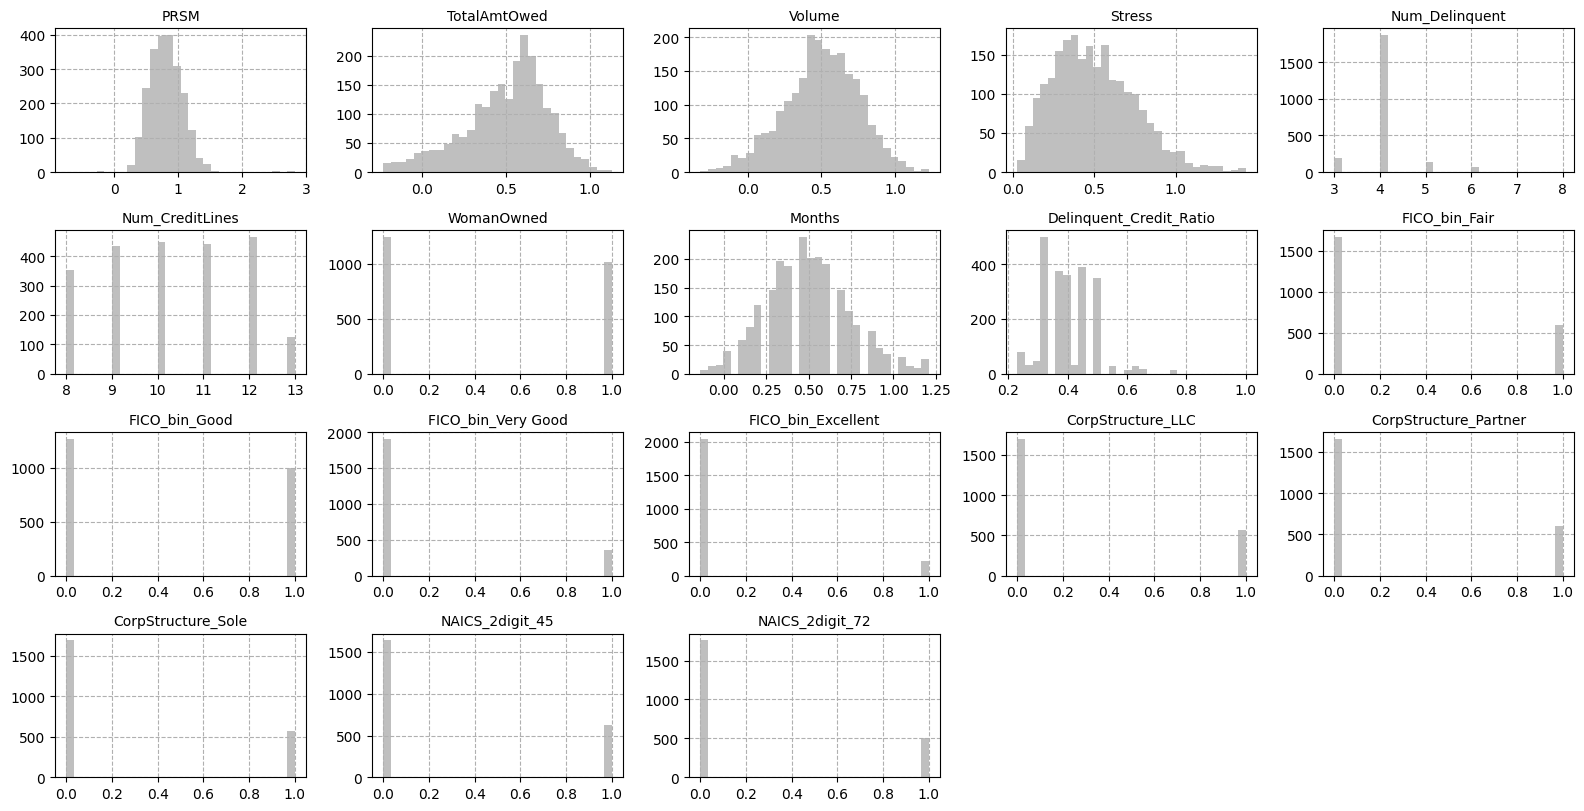

In [19]:
plt.figure(figsize=(16, 10), dpi=100)

for n, i in enumerate(df_train.iloc[:, 0:].columns):
    plt.subplot(5, 5, n+1) 
    plt.title(i, fontsize=10)  
    plt.grid(linestyle='--')
    df_train[i].hist(color='grey', alpha=0.5, bins=30)  

plt.tight_layout()
plt.show()

In [20]:
y = df_train['PRSM']
X = df_train.drop(columns=['PRSM'])

In [21]:
X = X.drop(['Num_Delinquent', 'Num_CreditLines', 'Volume'], axis=1)

In [22]:
model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=19)  

mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(mse_scores)

print(f'Average RMSE: {np.mean(rmse_scores):.4f}')
print(f'RMSE Standard Deviation: {np.std(rmse_scores):.4f}')

Average RMSE: 0.1558
RMSE Standard Deviation: 0.0374


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {rmse:.4f}')
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.1095
MSE: 0.0120
R²: 0.7954


In [24]:
X_train_sm = sm.add_constant(X_train) 
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     207.9
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:24:04   Log-Likelihood:                 643.53
No. Observations:                1812   AIC:                            -1257.
Df Residuals:                    1797   BIC:                            -1175.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [25]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()  
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)  

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                    Feature  Coefficient  Abs_Coefficient
0              TotalAmtOwed     0.321323         0.321323
2                WomanOwned     0.266889         0.266889
9         CorpStructure_LLC     0.238360         0.238360
8        FICO_bin_Excellent     0.232235         0.232235
1                    Stress     0.219087         0.219087
10    CorpStructure_Partner     0.155485         0.155485
7        FICO_bin_Very Good     0.124869         0.124869
6             FICO_bin_Good     0.113881         0.113881
3                    Months     0.113821         0.113821
5             FICO_bin_Fair     0.039259         0.039259
4   Delinquent_Credit_Ratio     0.032279         0.032279
12          NAICS_2digit_45    -0.009213         0.009213
11       CorpStructure_Sole    -0.002533         0.002533
13          NAICS_2digit_72    -0.001748         0.001748


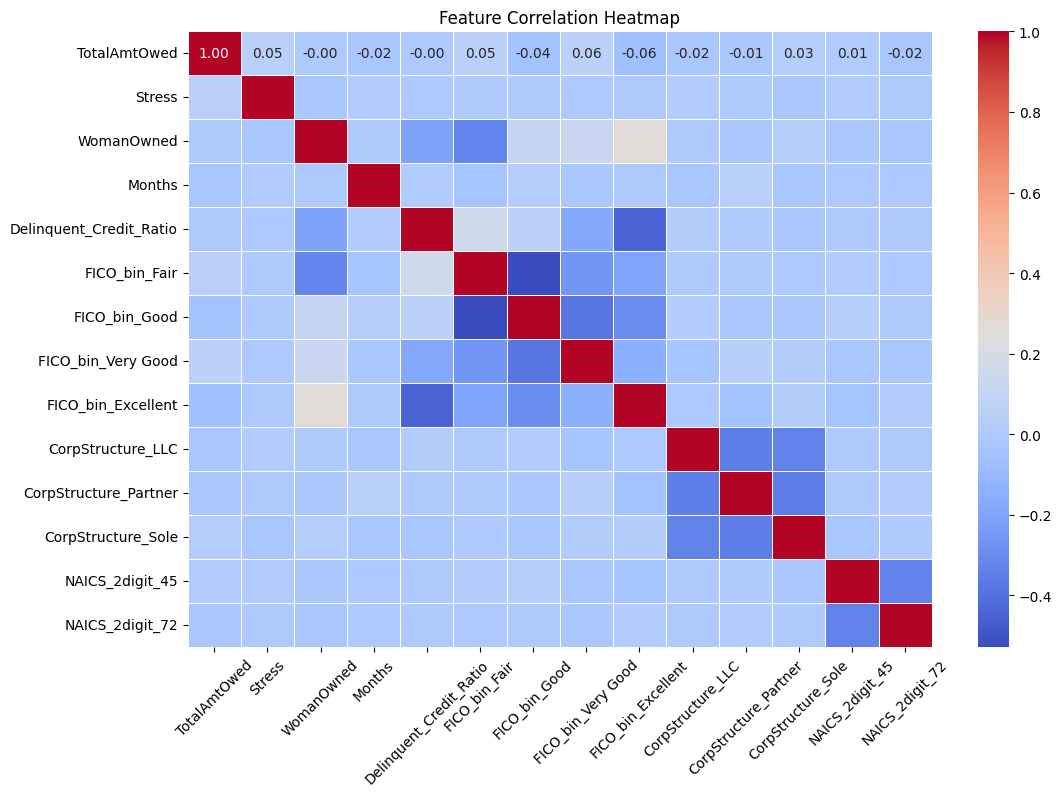

In [26]:
correlation_matrix = X.corr()

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45)
# 设置标题
plt.title('Feature Correlation Heatmap')

# 显示热力图
plt.show()

In [27]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
cols_to_check = ['Months', 'TotalAmtOwed', 'Stress'] 
X = df_train[cols_to_check]
X = add_constant(X)  # 添加常数项

# 计算每个特征的 VIF 值
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 显示 VIF 值
print(vif_data)

        Feature        VIF
0         const  67.076286
1        Months   1.000502
2  TotalAmtOwed  21.885714
3        Stress   9.371525
4        Volume  28.801306


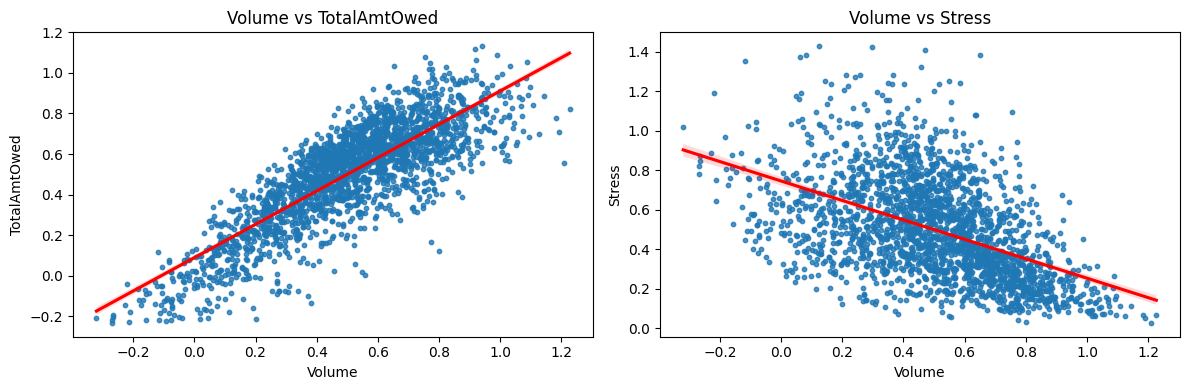

In [28]:
plt.figure(figsize=(12, 4))

# Volume vs TotalAmtOwed
plt.subplot(1, 2, 1)
sns.regplot(x='Volume', y='TotalAmtOwed', data=df_train, scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.title('Volume vs TotalAmtOwed')

# Volume vs Stress
plt.subplot(1, 2, 2)
sns.regplot(x='Volume', y='Stress', data=df_train, scatter_kws={'s': 10}, line_kws={"color": "red"})
plt.title('Volume vs Stress')

plt.tight_layout()
plt.show()

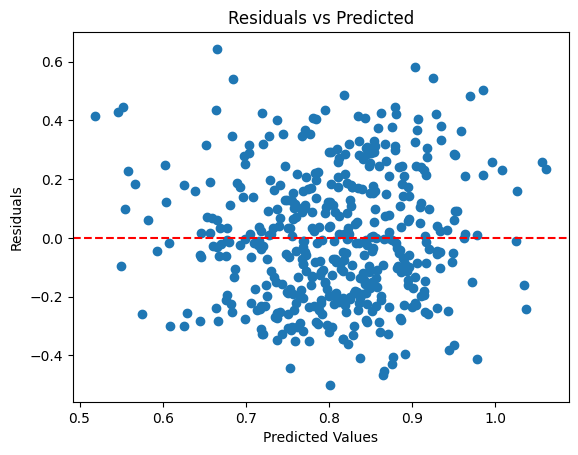

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()